In [1]:
%matplotlib inline

In [2]:
import tensorflow as tf
import tensorflow.contrib.slim as slim
from scipy.io import loadmat
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
import itertools
import math
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

In [3]:
import classifier_utils as utils

# Get the training data

In [4]:
categories = [
    'epithelial',
    'fibroblast',
    'inflammatory',
    'others',
]

In [5]:
# Read in the raw data
(raw_imgs, raw_centres, raw_labels) = utils.get_dataset(100, categories)

In [6]:
# Extract example patches from the data
H = 27
W = 27
(patches, labels, centres, img_ids) = utils.get_examples(
    raw_imgs, raw_centres, raw_labels, H, W)

Dropped 2082 patches because too close to image border


In [7]:
# Organize examples into training and test data
N = patches.shape[0]
num_train = int(0.8 * N)

np.random.seed(0) # predictable shuffling for now
perm = np.random.permutation(N)

train_patches, test_patches = np.split(patches[perm], [num_train])
train_labels, test_labels = np.split(labels[perm], [num_train])
train_centres, test_centres = np.split(centres[perm], [num_train])
train_img_ids, test_img_ids = np.split(img_ids[perm], [num_train])

# Convert to float
train_patches = train_patches / 255.0
test_patches = test_patches / 255.0

In [8]:
# Sanity check
train_patches.shape, train_labels.shape, test_patches.shape, test_labels.shape

((16289, 27, 27, 3), (16289, 4), (4073, 27, 27, 3), (4073, 4))

In [9]:
# Expand/augment the training data
desired_cnt_per_category = 15000
sorted_train_dict = utils.expand_training_data(
    raw_imgs, train_patches, train_labels, train_centres, train_img_ids, desired_cnt_per_category)
# Convert to float
sorted_train_dict['patches'] = sorted_train_dict['patches'] / 255.0

In [10]:
# Suffle the augmented training data
trainN = sorted_train_dict['patches'].shape[0]

np.random.seed(123) # predictable shuffling for now
perm = np.random.permutation(trainN)
train_dict = {k : v[perm] for (k, v) in sorted_train_dict.iteritems()}

In [11]:
sess = tf.InteractiveSession()

In [12]:
def upscale(images, scales, name):
    (yscale, xscale) = scales
    (batch_size, height, width, channels) = images.get_shape().as_list()
    with tf.name_scope(name):
        return tf.image.resize_images(images, height*yscale, width*xscale,
                                      method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

In [13]:
def autoencoder_model_1(image_batch):
    with slim.arg_scope([slim.conv2d, slim.fully_connected],
                        activation_fn=tf.nn.relu,
                        weights_initializer=tf.truncated_normal_initializer(stddev=0.01),
                        biases_initializer=tf.zeros_initializer,
                        #weights_regularizer=slim.l2_regularizer(0.0005),
                        biases_regularizer=None):
        with slim.arg_scope([slim.conv2d, slim.conv2d_transpose],
                            padding='VALID'):
            with slim.arg_scope([slim.dropout], keep_prob=0.8):
                with slim.arg_scope([slim.conv2d, slim.fully_connected, slim.conv2d_transpose],
                                    normalizer_fn=slim.batch_norm):
                    net = image_batch

                    estack = []
                    def r(x):
                        estack.append(x)
                        return x
                    with tf.variable_scope("encoder"):
                        net = r(slim.conv2d(net, 36, [4, 4], scope='1_conv'))
                        net = r(slim.conv2d(net, 42, [3, 3], scope='2_conv'))
                        net = r(slim.max_pool2d(net, [2, 2], scope='3_max_pool'))
                        net = r(slim.conv2d(net, 48, [4, 4], scope='4_conv'))
                        net = r(slim.max_pool2d(net, [2, 2], scope='5_max_pool'))
                        net = r(slim.flatten(net, scope='5_flatten'))
                        net = r(slim.fully_connected(net, 256, scope='6_fc'))
                        #net = r(slim.dropout(net, scope='6_dropout'))
                        net = r(slim.fully_connected(net, 64, scope='7_fc'))

                    encoded = net

                    dstack = []
                    def r(x):
                        dstack.append(x)
                        return x
                    with tf.variable_scope("decoder"):
                        net = r(slim.fully_connected(net, 256, scope='1_fc'))
                        #net = r(slim.dropout(net, scope='1_dropout'))
                        net = r(slim.fully_connected(net, 4*4*48, scope='2_fc'))
                        net = r(tf.reshape(net, [-1, 4, 4, 48], name='2_reshape'))
                        net = r(upscale(net, [2, 2], name='3_upscale'))
                        net = r(slim.conv2d_transpose(net, 42, [4, 4], scope='4_conv'))
                        net = r(upscale(net, [2, 2], name='5_upscale'))
                        net = r(slim.conv2d_transpose(net, 36, [3, 3], scope='6_conv'))
                        net = r(slim.conv2d_transpose(net, 3, [4, 4], scope='7_conv'))

                    reconstructed = net

                    return (encoded, reconstructed, estack, dstack)

In [14]:
def autoencoder_model_2(image_batch):
    with slim.arg_scope([slim.conv2d, slim.fully_connected],
                        activation_fn=tf.nn.relu,
                        weights_initializer=tf.truncated_normal_initializer(stddev=0.01),
                        biases_initializer=tf.zeros_initializer,
                        #weights_regularizer=slim.l2_regularizer(0.0005),
                        biases_regularizer=None):
        with slim.arg_scope([slim.conv2d, slim.conv2d_transpose],
                            padding='VALID'):
            with slim.arg_scope([slim.dropout], keep_prob=0.8):
                with slim.arg_scope([slim.conv2d, slim.fully_connected, slim.conv2d_transpose],
                                    normalizer_fn=slim.batch_norm):
                    net = image_batch

                    estack = []
                    def r(x):
                        estack.append(x)
                        return x
                    with tf.variable_scope("encoder"):
                        net = r(slim.conv2d(net, 36, [4, 4], scope='1_conv'))
                        net = r(slim.conv2d(net, 42, [3, 3], scope='2_conv'))
                        net = r(slim.max_pool2d(net, [2, 2], scope='3_max_pool'))
                        net = r(slim.conv2d(net, 48, [4, 4], scope='4_conv'))
                        net = r(slim.max_pool2d(net, [2, 2], scope='5_max_pool'))
                        net = r(slim.flatten(net, scope='5_flatten'))
                        net = r(slim.fully_connected(net, 256, scope='6_fc'))
                        #net = r(slim.dropout(net, scope='6_dropout'))
                        net = r(slim.fully_connected(net, 128, scope='7_fc'))

                    encoded = net

                    dstack = []
                    def r(x):
                        dstack.append(x)
                        return x
                    with tf.variable_scope("decoder"):
                        net = r(slim.fully_connected(net, 256, scope='1_fc'))
                        #net = r(slim.dropout(net, scope='1_dropout'))
                        net = r(slim.fully_connected(net, 4*4*48, scope='2_fc'))
                        net = r(tf.reshape(net, [-1, 4, 4, 48], name='2_reshape'))
                        net = r(upscale(net, [2, 2], name='3_upscale'))
                        net = r(slim.conv2d_transpose(net, 42, [4, 4], scope='4_conv'))
                        net = r(upscale(net, [2, 2], name='5_upscale'))
                        net = r(slim.conv2d_transpose(net, 36, [3, 3], scope='6_conv'))
                        net = r(slim.conv2d_transpose(net, 3, [4, 4], scope='7_conv'))

                    reconstructed = net

                    return (encoded, reconstructed, estack, dstack)

In [15]:
def autoencoder_model_3(image_batch):
    with slim.arg_scope([slim.conv2d, slim.fully_connected],
                        activation_fn=tf.nn.relu,
                        weights_initializer=tf.truncated_normal_initializer(stddev=0.01),
                        biases_initializer=tf.zeros_initializer,
                        #weights_regularizer=slim.l2_regularizer(0.0005),
                        biases_regularizer=None):
        with slim.arg_scope([slim.conv2d, slim.conv2d_transpose],
                            padding='VALID'):
            with slim.arg_scope([slim.dropout], keep_prob=0.8):
                with slim.arg_scope([slim.conv2d, slim.fully_connected, slim.conv2d_transpose],
                                    normalizer_fn=slim.batch_norm):
                    net = image_batch

                    estack = []
                    def r(x):
                        estack.append(x)
                        return x
                    with tf.variable_scope("encoder"):
                        net = r(slim.conv2d(net, 36, [4, 4], scope='1_conv'))
                        net = r(slim.conv2d(net, 42, [3, 3], scope='2_conv'))
                        net = r(slim.max_pool2d(net, [2, 2], scope='3_max_pool'))
                        net = r(slim.conv2d(net, 48, [4, 4], scope='4_conv'))
                        net = r(slim.max_pool2d(net, [2, 2], scope='5_max_pool'))
                        net = r(slim.flatten(net, scope='5_flatten'))
                        net = r(slim.fully_connected(net, 256, scope='6_fc'))
                        #net = r(slim.dropout(net, scope='6_dropout'))
                        net = r(slim.fully_connected(net, 128, scope='7_fc'))

                    encoded = net

                    dstack = []
                    def r(x):
                        dstack.append(x)
                        return x
                    with tf.variable_scope("decoder"):
                        net = r(slim.fully_connected(net, 256, scope='1_fc'))
                        #net = r(slim.dropout(net, scope='1_dropout'))
                        net = r(slim.fully_connected(net, 4*4*48, scope='2_fc'))
                        net = r(tf.reshape(net, [-1, 4, 4, 48], name='2_reshape'))
                        net = r(upscale(net, [2, 2], name='3_upscale'))
                        net = r(slim.conv2d_transpose(net, 42, [4, 4], scope='4_conv'))
                        net = r(upscale(net, [2, 2], name='5_upscale'))
                        net = r(slim.conv2d_transpose(net, 36, [3, 3], scope='6_conv'))
                        net = r(slim.conv2d_transpose(net, 3, [4, 4], activation_fn=tf.nn.sigmoid, scope='7_conv'))

                    reconstructed = net

                    return (encoded, reconstructed, estack, dstack)

In [16]:
if sess is not None:
    sess.close()
tf.reset_default_graph()
sess = tf.InteractiveSession()
patch_tensor = tf.placeholder(dtype='float32', shape=(None, 27, 27, 3))
with tf.variable_scope("autoencoder"):
    with slim.arg_scope([slim.dropout], is_training=True), slim.arg_scope([slim.conv2d, slim.conv2d_transpose], normalizer_params={'is_training':True}):
        (encoded_tensor, reconstructed_tensor, estack, dstack) = autoencoder_model_3(patch_tensor)
with tf.variable_scope("autoencoder", reuse=True):
    with slim.arg_scope([slim.dropout], is_training=False), slim.arg_scope([slim.conv2d, slim.conv2d_transpose], normalizer_params={'is_training':False}):
        (eval_encoded_tensor, eval_reconstructed_tensor, eval_estack, eval_dstack) = autoencoder_model_3(patch_tensor)

print "Encoded:", encoded_tensor.get_shape().as_list()
print "Reconstructed:", reconstructed_tensor.get_shape().as_list()

Encoded: [None, 128]
Reconstructed: [None, 27, 27, 3]


In [17]:
def get_training_op(reconstructed_tensor, patch_tensor, lr_tensor):
    difference = reconstructed_tensor - patch_tensor
    #print difference.get_shape().as_list()
    square_difference = tf.square(difference)
    mean_squared_error = tf.reduce_mean(square_difference)
    slim.losses.add_loss(mean_squared_error)
    total_loss = slim.losses.get_total_loss()
    optimizer = tf.train.AdamOptimizer(learning_rate=lr_tensor)#learning_rate=0.01)
    #optimizer = tf.train.AdamOptimizer()
    train_op = slim.learning.create_train_op(total_loss, optimizer)
    return (train_op, mean_squared_error)

In [18]:
lr_tensor = tf.placeholder(dtype='float32', shape=[])
(train_op, loss) = get_training_op(reconstructed_tensor, patch_tensor, lr_tensor)

In [19]:
def train_loop(sess, patch_tensor, reconstructed_tensor, eval_reconstructed_tensor, train_patches, test_patches, train_op, loss_tensor, epochs, batch_size, reset=True):
    if not os.path.exists("imgs/train"):
        os.makedirs("imgs/train")
    if not os.path.exists("imgs/test"):
        os.makedirs("imgs/test")
    tr_loss = []
    tst_loss = []
    N = train_patches.shape[0]
    if reset:
        sess.run(tf.initialize_all_variables())
    for e in xrange(epochs):
        for i in xrange(0, N, batch_size):
            [total_loss, loss] = sess.run([train_op, loss_tensor], feed_dict={
                    lr_tensor:0.001,
                    patch_tensor:train_patches[i:i+batch_size],
                })
            step = i / batch_size
            if step % 50 == 0:
                #[test_loss] = sess.run([loss_tensor], feed_dict={
                #    patch_tensor:test_patches,
                #})
                test_loss = 0
                print "Epoch %d, step %d, total loss %f, training loss %f, test_loss %f" % (e, step, total_loss, loss, test_loss)
                tr_loss.append(loss)
                tst_loss.append(test_loss)
                #print "Starting print"
                imgs = sess.run(eval_reconstructed_tensor, feed_dict={
                    patch_tensor:train_patches[:16],
                })
                #plt.figure()
                for i in range(16):
                    plt.subplot(4,4,i+1)
                    plt.imshow(imgs[i])
                plt.savefig("imgs/train/%d_%d.png" % (e, step))
                #print "Done print training"
                imgs = sess.run(eval_reconstructed_tensor, feed_dict={
                    patch_tensor:test_patches[:16],
                })
                #plt.figure()
                for i in range(16):
                    plt.subplot(4,4,i+1)
                    plt.imshow(imgs[i])
                plt.savefig("imgs/test/%d_%d.png" % (e, step))
                #print "Done print testing"
        # End-of-epoch printing
        #[test_loss] = sess.run([loss_tensor], feed_dict={
        #    patch_tensor:test_patches,
        #})
        test_loss = 0
        print "End of epoch %d, training loss %f, test_loss %f" % (e, loss, test_loss)
        # Save the model
        saver = tf.train.Saver()
        os.makedirs("autoencoder_models/autosave/v%d" % e)
        save_path = saver.save(sess, "autoencoder_models/autosave/v%d/model.ckpt" % e)
        print "Saved to:", save_path
    #print "Final training loss %f" % (loss)
    return (tr_loss, tst_loss)

In [ ]:
tr_loss, tst_loss = train_loop(
    sess, patch_tensor, reconstructed_tensor, eval_reconstructed_tensor, train_dict['patches'], test_patches, train_op, loss, 500, 100, reset=False)

Epoch 0, step 0, total loss 0.026120, training loss 0.026120, test_loss 0.000000
Epoch 0, step 50, total loss 0.012017, training loss 0.012017, test_loss 0.000000
Epoch 0, step 100, total loss 0.011236, training loss 0.011236, test_loss 0.000000
Epoch 0, step 150, total loss 0.009041, training loss 0.009041, test_loss 0.000000
Epoch 0, step 200, total loss 0.008299, training loss 0.008299, test_loss 0.000000
Epoch 0, step 250, total loss 0.007473, training loss 0.007473, test_loss 0.000000
Epoch 0, step 300, total loss 0.007451, training loss 0.007451, test_loss 0.000000
Epoch 0, step 350, total loss 0.006982, training loss 0.006982, test_loss 0.000000
Epoch 0, step 400, total loss 0.006921, training loss 0.006921, test_loss 0.000000
Epoch 0, step 450, total loss 0.006179, training loss 0.006179, test_loss 0.000000
Epoch 0, step 500, total loss 0.006674, training loss 0.006674, test_loss 0.000000
Epoch 0, step 550, total loss 0.006102, training loss 0.006102, test_loss 0.000000
End of 

In [332]:
# Save the model
saver = tf.train.Saver()
save_path = saver.save(sess, "autoencoder_models/v3/model.ckpt")
print "Saved to:", save_path

Saved to: autoencoder_models/v3/model.ckpt


In [20]:
# Restore the model
saver = tf.train.Saver()
saver.restore(sess, "autoencoder_models/autosave-1/v29/model.ckpt")

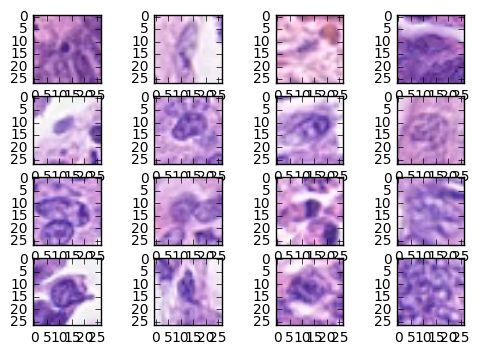

In [325]:
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(train_dict['patches'][i])
plt.savefig("train_golden.png")
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(test_patches[i])
plt.savefig("test_golden.png")

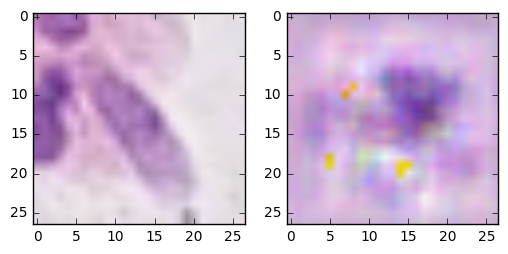

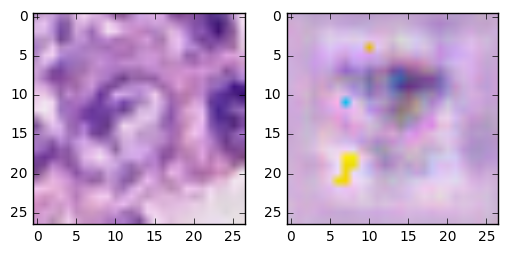

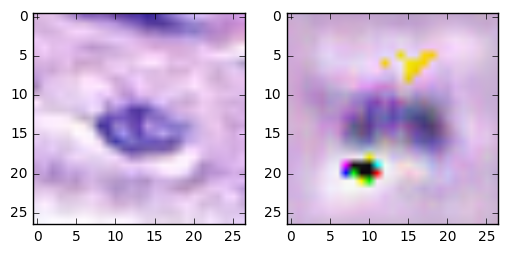

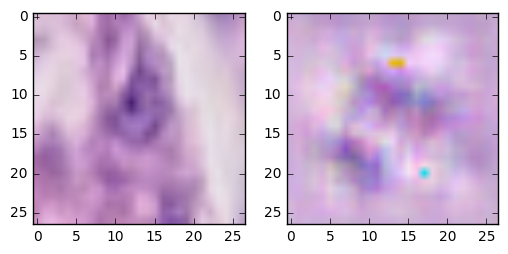

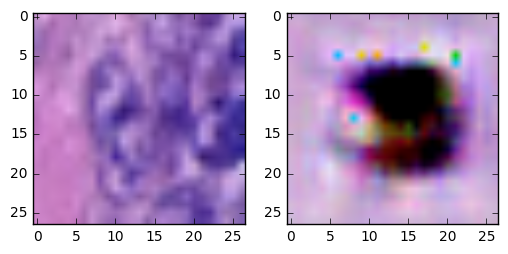

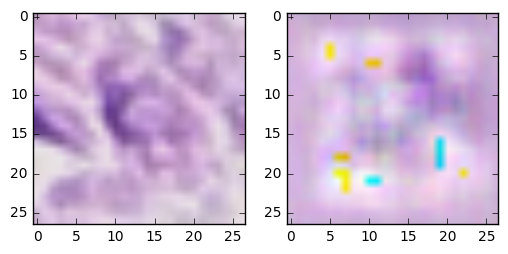

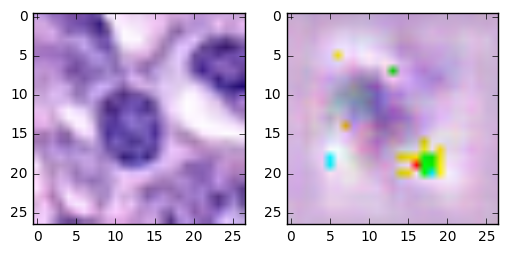

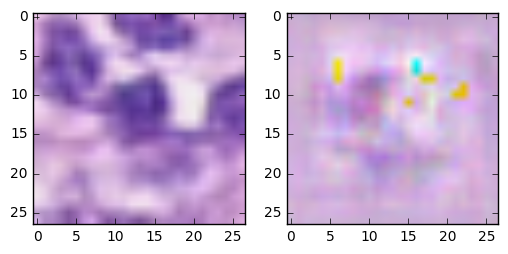

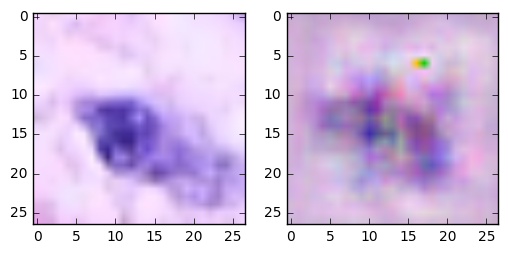

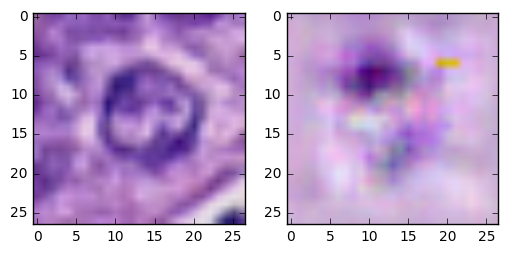

In [298]:
#img = train_dict['patches'][1]
#plt.imshow(img)
imgs = eval_reconstructed_tensor.eval(feed_dict={
        patch_tensor:train_dict['patches'][:10]
    })
for i in xrange(len(imgs)):
    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(train_dict['patches'][i])
    plt.subplot(1,2,2)
    plt.imshow(imgs[i])

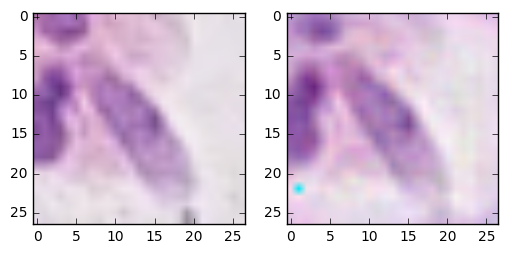

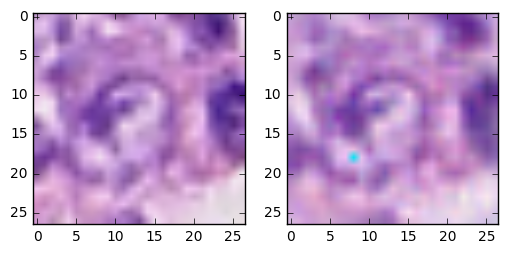

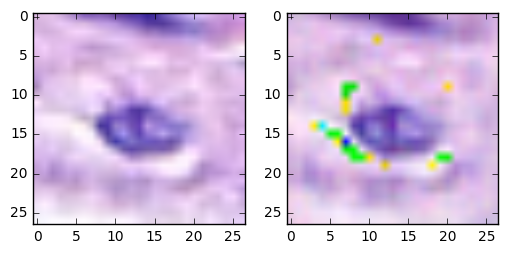

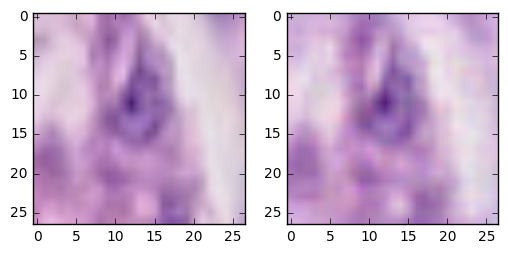

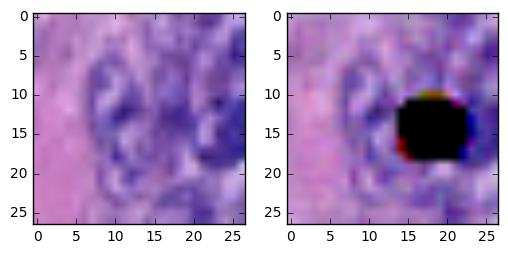

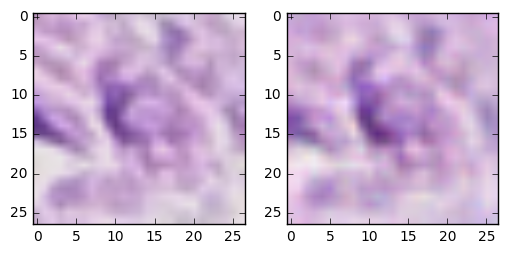

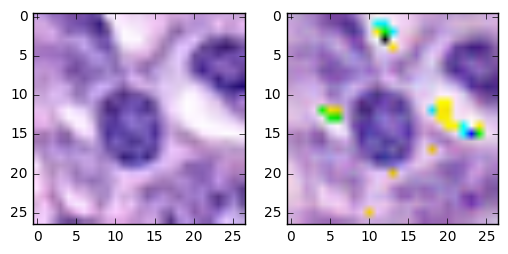

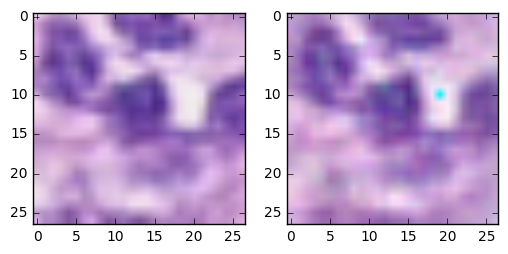

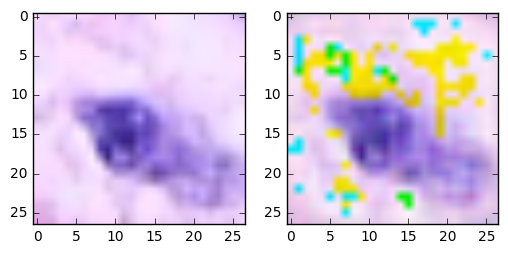

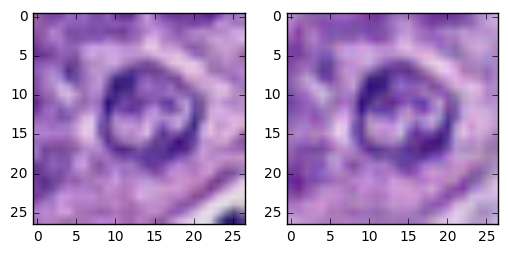

In [296]:
#img = train_dict['patches'][1]
#plt.imshow(img)
imgs = eval_reconstructed_tensor.eval(feed_dict={
        patch_tensor:train_dict['patches'][:10]
    })
for i in xrange(len(imgs)):
    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(train_dict['patches'][i])
    plt.subplot(1,2,2)
    plt.imshow(imgs[i])

In [153]:
eval_dstack

[<tf.Tensor 'autoencoder_1/decoder/1_fc/Relu:0' shape=(?, 256) dtype=float32>,
 <tf.Tensor 'autoencoder_1/decoder/1_fc/Relu:0' shape=(?, 256) dtype=float32>,
 <tf.Tensor 'autoencoder_1/decoder/2_fc/Relu:0' shape=(?, 768) dtype=float32>,
 <tf.Tensor 'autoencoder_1/decoder/2_reshape:0' shape=(?, 4, 4, 48) dtype=float32>,
 <tf.Tensor 'autoencoder_1/decoder/3_upscale/ResizeNearestNeighbor:0' shape=(?, 8, 8, 48) dtype=float32>,
 <tf.Tensor 'autoencoder_1/decoder/4_conv/Relu:0' shape=(?, 11, 11, 42) dtype=float32>,
 <tf.Tensor 'autoencoder_1/decoder/5_upscale/ResizeNearestNeighbor:0' shape=(?, 22, 22, 42) dtype=float32>,
 <tf.Tensor 'autoencoder_1/decoder/6_conv/Relu:0' shape=(?, 24, 24, 36) dtype=float32>,
 <tf.Tensor 'autoencoder_1/decoder/7_conv/Relu:0' shape=(?, 27, 27, 3) dtype=float32>]

In [38]:
[v.name for v in tf.all_variables()]

[u'autoencoder/encoder/1_conv/weights:0',
 u'autoencoder/encoder/1_conv/BatchNorm/beta:0',
 u'autoencoder/encoder/1_conv/BatchNorm/moving_mean:0',
 u'autoencoder/encoder/1_conv/BatchNorm/moving_variance:0',
 u'autoencoder/encoder/2_conv/weights:0',
 u'autoencoder/encoder/2_conv/BatchNorm/beta:0',
 u'autoencoder/encoder/2_conv/BatchNorm/moving_mean:0',
 u'autoencoder/encoder/2_conv/BatchNorm/moving_variance:0',
 u'autoencoder/encoder/4_conv/weights:0',
 u'autoencoder/encoder/4_conv/BatchNorm/beta:0',
 u'autoencoder/encoder/4_conv/BatchNorm/moving_mean:0',
 u'autoencoder/encoder/4_conv/BatchNorm/moving_variance:0',
 u'autoencoder/encoder/6_fc/weights:0',
 u'autoencoder/encoder/6_fc/BatchNorm/beta:0',
 u'autoencoder/encoder/6_fc/BatchNorm/moving_mean:0',
 u'autoencoder/encoder/6_fc/BatchNorm/moving_variance:0',
 u'autoencoder/encoder/7_fc/weights:0',
 u'autoencoder/encoder/7_fc/BatchNorm/beta:0',
 u'autoencoder/encoder/7_fc/BatchNorm/moving_mean:0',
 u'autoencoder/encoder/7_fc/BatchNorm/m

In [207]:
g = tf.gradients(loss, [var])
print g
g = g[0]
thing = tf.transpose(g[:, :, 0, :]).eval(feed_dict={
        patch_tensor:train_dict['patches'][:1],
    })
thing.shape

[<tf.Tensor 'gradients_11/autoencoder/decoder/7_conv/conv2d_transpose_grad/Conv2DBackpropFilter:0' shape=(4, 4, 3, 36) dtype=float32>]


(36, 4, 4)

In [208]:
for i in thing:
    for j in i:
        print j
    print "\n"

[ -1.42472818e-05  -8.73056342e-06   6.27996087e-06  -2.41541784e-06]
[ -7.50293384e-06  -1.75719106e-05  -2.30083588e-05  -9.78350090e-06]
[ -1.83652446e-07  -2.33550181e-05  -2.94155816e-05  -1.13981569e-05]
[ -1.58249277e-05  -2.37142358e-05  -2.82495548e-05  -2.95722930e-05]


[  5.38209042e-06  -3.60879562e-06   8.61385888e-06   1.05155741e-05]
[  7.64571814e-06  -9.48162779e-06   1.13208444e-06   9.79240485e-06]
[  9.39968322e-06  -1.53799938e-05  -1.05782829e-05  -1.52458597e-08]
[ -1.11723630e-05  -7.65527784e-06  -7.26492362e-06  -8.21742469e-06]


[  5.81092991e-06  -8.84776182e-06   2.33840055e-05  -2.43370323e-06]
[  1.74736088e-05  -1.49841253e-06  -8.78811079e-07  -3.57993940e-07]
[  1.42767840e-05  -1.85746048e-05  -7.09578217e-06   1.17356058e-05]
[ -1.66229001e-05  -2.48931883e-05  -1.77760612e-05  -9.13006352e-06]


[  2.01448620e-05   4.41189695e-06  -1.40372310e-06  -5.80462165e-06]
[ -2.95997434e-05  -1.19460528e-05  -1.14128243e-05   4.20343122e-06]
[ -1.60762211e

(27, 27, 3)


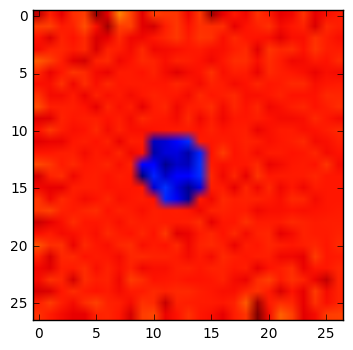

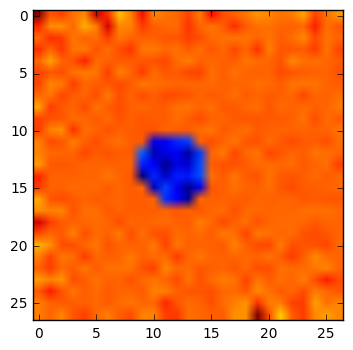

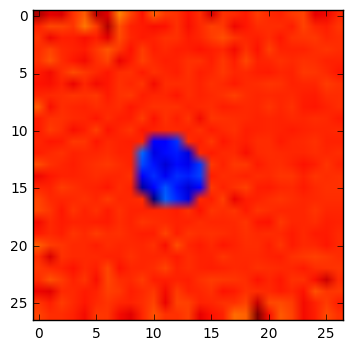

In [190]:
#thing = eval_dstack[8].eval(feed_dict={patch_tensor:train_dict['patches'][:1]})[0]
thing = (reconstructed_tensor - patch_tensor).eval(feed_dict={patch_tensor:train_dict['patches'][:1]})[0]
#thing = eval_dstack[8].eval(feed_dict={eval_dstack[7]:np.random.uniform(size=[1,24,24,36])})[0]
#thing2 = eval_dstack[4].eval(feed_dict={patch_tensor:train_dict['patches'][:1]})[0]
for i in xrange(thing.shape[-1]):
    plt.figure()
    plt.imshow(thing[:, :, i])
    #print thing[15,12,i]
    #print thing[:, :, i]
    #print thing2[:, :, i]
    #pass
#t2 = eval_dstack[2].eval(feed_dict={patch_tensor:train_dict['patches'][:1]})[0]
#plt.plot(xrange(len(t0)), t0)
print thing.shape


In [110]:
rimg1[15][15]

array([ 0.,  0.,  0.], dtype=float32)

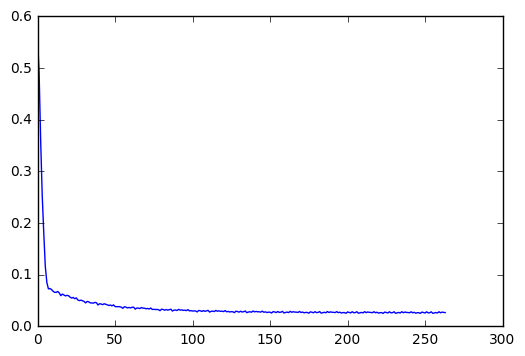

In [86]:
x = xrange(len(tr_loss + tr_loss2))
plt.plot(x, tr_loss + tr_loss2, label='train')

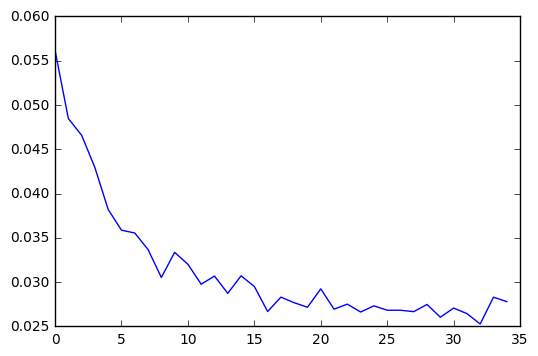

In [41]:
@interact(s=widgets.IntSlider(min=0,max=23,step=1,value=0))
def f(s):
    x = xrange(len((tr_loss + tr_loss2)[s::7]))
    plt.plot(x, (tr_loss + tr_loss2)[s::7], label='train')

# For reference

In [20]:
images = tf.placeholder(tf.float32, shape=(None, 3, 3, 1))
img = np.array([[1, 2, 3],
                [4, 5, 6],
                [7, 8, 9]])
resized = tf.image.resize_images(images, 6, 6, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
resized_img = resized.eval(feed_dict={
        images: img[np.newaxis, :, :, np.newaxis],
    })
resized_img[0, :, :, 0]

array([[ 1.,  1.,  2.,  2.,  3.,  3.],
       [ 1.,  1.,  2.,  2.,  3.,  3.],
       [ 4.,  4.,  5.,  5.,  6.,  6.],
       [ 4.,  4.,  5.,  5.,  6.,  6.],
       [ 7.,  7.,  8.,  8.,  9.,  9.],
       [ 7.,  7.,  8.,  8.,  9.,  9.]], dtype=float32)

In [25]:
images = tf.placeholder(tf.float32, shape=(None, 3, 3, 14))
img = np.array([[[1]*14, [2]*14, [3]*14],
                [[4]*14, [5]*14, [6]*14],
                [[7]*14, [8]*14, [9]*14]])
resized = tf.image.resize_images(images, 6, 6, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
resized_img = resized.eval(feed_dict={
        images: img[np.newaxis, :, :],
    })
resized_img[0, :, :, 13]

array([[ 1.,  1.,  2.,  2.,  3.,  3.],
       [ 1.,  1.,  2.,  2.,  3.,  3.],
       [ 4.,  4.,  5.,  5.,  6.,  6.],
       [ 4.,  4.,  5.,  5.,  6.,  6.],
       [ 7.,  7.,  8.,  8.,  9.,  9.],
       [ 7.,  7.,  8.,  8.,  9.,  9.]], dtype=float32)

In [31]:
resized.get_shape().as_list()

[None, 6, 6, 14]